In [ ]:
!pip install turicreate==5.4
# The wrong version of MXNET will be installed
!pip uninstall -y mxnet
# Install CUDA10-compatible version of mxnet 
!pip install mxnet-cu100==1.4.0.post0

     |████████████████████████████████| 87.4MB 97kB/s 
     |████████████████████████████████| 2.7MB 53.3MB/s 
     |████████████████████████████████| 327kB 65.3MB/s 
     |████████████████████████████████| 23.8MB 168kB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320847 sha256=2c637f4ee02ab23c6f899d20af726825b32e06bf96c36105e1d00c468544d5a0
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
ERROR: mxnet 1.1.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.17.4 which is incompatible.
ERROR: mxnet 1.1.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.21.0 which is incompatible.
  Found existing installation: resampy 0.2.2
    Uninstalling resampy-0.2.2:
      Successfully uninstalled resampy-0.2.2
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Un

In [ ]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import mxnet as mx
import turicreate as tc

         To fix this, please install the currently recommended version:

             pip uninstall -y mxnet && pip install mxnet==1.1.0

         If you want to use a CUDA GPU, then change 'mxnet' to 'mxnet-cu90' (adjust 'cu90' depending on your CUDA version):



In [ ]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox

# Data loading

In [ ]:
base_db = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/ML_Project/base_db.csv").drop(columns="Unnamed: 0")
base_db.head()

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
0,10108642,S,48.0,T,46.900000,Actinopterygii,Cypriniformes,Cyprinidae,Carassius,auratus,NR,1.93 (0.82-4.15) G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
1,88302,S,6.0,A,2.920000,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,FI,NR,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
2,1397940,S,96.0,A,0.000063,Actinopterygii,Perciformes,Centrarchidae,Micropterus,salmoides,NR,20.5G,Fish
3,25474413,S,96.0,A,0.012000,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NR,1G,"Fish,Standard Test Species"
4,540727,F,36.0,T,144.000000,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,JV,0.62 G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."


In [ ]:
X_original = base_db.copy()
X_original = X_original[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]
X_original.head()

,test_cas,species,conc1_mean,obs_duration_mean
0,10108642,auratus,46.900000,48.0
1,88302,mykiss,2.920000,6.0
2,1397940,salmoides,0.000063,96.0
3,25474413,macrochirus,0.012000,96.0
4,540727,mykiss,144.000000,36.0


In [ ]:
X_original = X_original[X_original.obs_duration_mean==96]

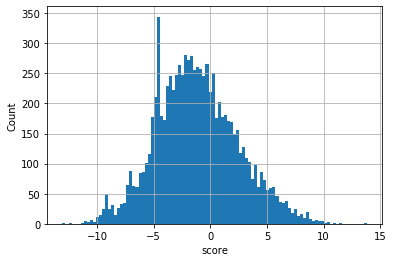

In [ ]:
X_original = X_original.groupby(by=["test_cas", "species"]).agg("median").reset_index()
X_original["score"] = 1/X_original.conc1_mean

enc = OrdinalEncoder(dtype=int)
enc.fit(X_original[["test_cas", "species"]])
X_original[["test_cas", "species"]] = enc.transform(X_original[["test_cas", "species"]])
X_fact = X_original.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index(drop=True)

X_fact_scored = X_fact.copy()
X_fact_scored.score = X_fact_scored.score.apply(lambda x: np.log(x))

# plotting the distribution of conc inside this case
X_fact_scored.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

# Basic tests

In [ ]:
minmax = MinMaxScaler((1, 10))
minmax.fit(X_fact_scored[["score"]])
X_fact_scored[["score"]] = minmax.transform(X_fact_scored[["score"]])

In [ ]:
X = tc.SFrame(X_fact_scored)
X

test_cas,species,score
0,3,3.73776068951641
0,71,3.9409040271072886
0,82,3.5470584567157486
0,131,3.7821664371731405
0,167,3.8158482108284737
0,188,4.336227075933329
0,220,4.62287915355913
0,267,3.695395497824532
0,278,3.66428473194256
0,316,4.300170308995456


In [ ]:
X_train, X_test = tc.recommender.util.random_split_by_user(X, 'test_cas', 'species', max_num_users=1000, item_test_proportion=0.3)

In [ ]:
X_train

test_cas,species,score
0,3,3.73776068951641
0,71,3.9409040271072886
0,82,3.5470584567157486
0,131,3.7821664371731405
0,167,3.8158482108284737
0,188,4.336227075933329
0,220,4.62287915355913
0,267,3.695395497824532
0,278,3.66428473194256
0,316,4.300170308995456


In [ ]:
model = tc.recommender.factorization_recommender.create(X_train, 'test_cas', 'species', target='score', max_iterations=1000)

Preparing data set.

Data has 7835 observations with 2434 users and 398 items.

Data prepared in: 0.018125s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 7835 / 7835 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.181266                                 |

| 5       | 0.0488281         | 0.386393                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.181266                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 51us         | 1.4636            | 1.2098                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 13.092ms     | 0.83559           | 0.914103              | 0.0976562   |

| 2       | 20.461ms     | 0.397365          | 0.630366              | 0.0580668   |

| 3       | 32.557ms     | 0.259348          | 0.50926               | 0.042841    |

| 4       | 42.383ms     | 0.217002          | 0.465833              | 0.0345267   |

| 5       | 52.986ms     | 0.197514          | 0.444424              | 0.029206    |

| 10      | 90.458ms     | 0.164391          | 0.40545               | 0.017366    |

| 50      | 368.971ms    | 0.0703287         | 0.265188              | 0.00519365  |

| 100     | 740.933ms    | 0.0398358         | 0.199577              | 0.00308816  |

| 500     | 3.52s        | 0.0153239         | 0.123761              | 0.000923576 |

| 998     | 6.94s        | 0.0121865         | 0.110358              | 0.000549987 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.012105

Final training RMSE: 0.109987

In [ ]:
model.evaluate_rmse(X_test, 'score')['rmse_overall']

0.7715130785386505

In [ ]:
X_test_predict = model.predict(X_test)
X_test_predict

dtype: float
Rows: 965
[3.9160337816464166, 4.810775741516278, 4.851452663122342, 4.800073250709699, 5.136536418973134, 4.870240822015927, 5.054302647291348, 4.583175576804803, 4.784727163194344, 4.910451225517915, 4.243887159554885, 4.564487978397534, 3.6400225307332734, 4.025586410938428, 5.004235103307889, 3.6812742497312287, 4.776622958062814, 4.71658716308944, 4.780518106697724, 5.318326353608296, 4.8092863630043725, 4.953789934097455, 5.2340459297882775, 5.316194548784421, 4.268355853437112, 5.349353767512963, 4.951050944207833, 5.984901465057061, 4.450408197520898, 6.068476713775323, 5.054538309155629, 5.8887144695507745, 5.2965687583672265, 4.583175576804803, 4.583175576804803, 4.809798817663119, 3.427967346786187, 2.3084558616863946, 4.47715834486358, 4.583175576804803, 2.344780720351861, 4.451930380939172, 4.490950531839059, 3.320861391304658, 1.9813415180432061, 1.722489870666192, 2.614134855149911, 3.90797293889396, 2.641703463672326, 4.356294668792413, 4.359837449668572, 4

In [ ]:
X_test_score = X_test.select_column("score")
X_test_score

dtype: float
Rows: 965
[3.71626758495354, 4.45549735579243, 4.861233688970261, 4.727108359310469, 5.572018639025107, 5.273694832287757, 4.5535430209347885, 2.5027354353987956, 5.036524220827172, 5.775076917686039, 4.600363913668467, 4.965734703737563, 4.266381541200065, 4.654808501629203, 4.956879441190712, 4.450320105134525, 4.993581238075765, 5.166557125864623, 5.235907823589456, 5.247264999137658, 5.214287122531501, 5.050353766222792, 5.700322802919587, 5.631881209127953, 4.243680925710945, 5.371740497430115, 4.977659640076738, 5.766804779035413, 5.045258541101527, 5.4960485352872945, 5.233681871255022, 6.230675477833476, 5.440271437693488, 4.064561728252011, 1.8756731074574153, 4.734026104103338, 4.00123480775986, 2.2862341623835247, 4.673447179116967, 3.82898732990682, 3.078339290633779, 2.9570743290547123, 3.2123947476071573, 3.564850492171681, 2.1415850693601715, 1.9401126142228828, 2.2930021621420305, 3.9733015857270875, 2.8515207310119606, 3.9733015857270875, 4.243680925710945

In [ ]:
tc.evaluation.rmse(X_test_score, X_test_predict)

0.7715130785386507

In [ ]:
X_test_predict_conc = minmax.inverse_transform(X_test_predict.to_numpy().reshape(-1, 1))
X_test_predict_conc = np.exp(X_test_predict_conc)    
X_test_predict_conc = 1/X_test_predict_conc

In [ ]:
X_test_conc = minmax.inverse_transform(X_test_score.to_numpy().reshape(-1, 1))
X_test_conc = np.exp(X_test_conc)    
X_test_conc = 1/X_test_conc

In [ ]:
sqrt(mean_squared_error(X_test_conc, X_test_predict_conc))

3437.5215768480975

# Implementing CV

In [ ]:
X_train_original, X_test_original, X_train_scored, X_test_scored = train_test_split(X_original, X_fact_scored, test_size=0.33)

In [ ]:
X_train_original = X_train_original.reset_index(drop=True)
X_test_original = X_test_original.reset_index(drop=True)
X_train_scored = X_train_scored.reset_index(drop=True)
X_test_scored = X_test_scored.reset_index(drop=True)

In [ ]:
factors = range(10, 211, 20)
regularizs = np.logspace(-12, 0, 10)
lin_regularizs = np.logspace(-12, 0, 10)
best_rmse, best_scale, best_params = cv_scale(X_train_original, X_train_scored, factors, regularizs, lin_regularizs, max_scale=15, min_scale=5, step_size= 1, params_sample=False)
pickle.dump(best_rmse, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_rmse.pkl", "wb" ) )
pickle.dump(best_scale, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_scale.pkl", "wb" ) )
pickle.dump(best_params, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_params.pkl", "wb" ) )

New best param combination found! Rmse:0.4169126203830466, num_factors:10, regularizer:1e-12, lin_reg:1e-12
New best param combination found! Rmse:0.4104402772096032, num_factors:10, regularizer:1e-12, lin_reg:2.1544346900318868e-11
New best param combination found! Rmse:0.409606695792151, num_factors:10, regularizer:1e-12, lin_reg:4.641588833612773e-06
New best param combination found! Rmse:0.39463293521413423, num_factors:10, regularizer:1e-12, lin_reg:0.0001
New best param combination found! Rmse:0.3942202721593308, num_factors:10, regularizer:4.641588833612773e-06, lin_reg:0.0001
New best param combination found! Rmse:0.3938525846307431, num_factors:10, regularizer:0.0021544346900318778, lin_reg:2.1544346900318868e-11
New best param combination found! Rmse:0.413360473331761, num_factors:10, regularizer:1e-12, lin_reg:1e-12
New best param combination found! Rmse:0.40304832540592433, num_factors:10, regularizer:1e-12, lin_reg:2.1544346900318868e-11
New best param combination found! R

In [ ]:
def cv_scale(X_real, X_real_scored, list_factors, list_regulariz, list_lin_regulariz, min_scale = 10, max_scale = 50, step_size=10, cv = 3, params_sample=True):
    best_scale = 0
    best_rmse = np.inf
    best_params = []
    best_model = None
    cas = X_real.test_cas.max()
    species = X_real.species.max()
    
    for scale in range(min_scale, max_scale+1, step_size):
        
        X_real_score = X_real_scored.copy()

        # MinMax scale score
        minmax = MinMaxScaler((1, scale))
        minmax.fit(X_real_score[["score"]])
        X_real_score[["score"]] = minmax.transform(X_real_score[["score"]])
        
        kf = KFold(n_splits=cv, shuffle=True)
        
        rmses = []
        params = []
        
        for train_index, test_index in kf.split(X_real_score):
            model, param = cv_fact(X_real_score.loc[train_index].reset_index(drop=True), factors=list_factors, regularizs=list_regulariz, lin_regulars = list_lin_regulariz, cv=cv, params_samples=params_sample)
            params.append(param)

            # rmse
            X_test = tc.SFrame(X_real_score.loc[test_index])
            rmses.append(model.evaluate_rmse(X_test, 'score')['rmse_overall'])
        
        avg_rmse = np.mean(rmses)
        print("Scale: {}, avg_rmse: {}".format(scale, avg_rmse))
        if (avg_rmse < best_rmse):
            print("New best scale found:", scale)
            print("New best rmse", avg_rmse)
            best_rmse = avg_rmse
            best_scale = scale
            best_params = params
          
    return best_rmse, best_scale, best_params

In [ ]:
def cv_fact(X_train_scored, factors, regularizs, lin_regulars,  cv = 3, verbose=True, params_samples = True, num_samples = 5):
  best_factor = 0
  best_regulariz = 0
  best_lin_regulariz = 0
  best_rmse = np.inf
  best_model = None

  if params_samples:
    factors = np.random.choice(factors, num_samples)
    regularizs = np.random.choice(regularizs, num_samples)
    lin_regulars = np.random.choice(lin_regulars, num_samples)
    
  for factor in factors:
    for regulariz in regularizs:
      for lin_regular in lin_regulars:
        rmses = []
        kf2 = KFold(n_splits=cv, shuffle=True)

        for train_ind, test_ind in kf2.split(X_train_scored):
          train = tc.SFrame(X_train_scored.loc[train_ind])
          test = tc.SFrame(X_train_scored.loc[test_ind])

          model = tc.recommender.factorization_recommender.create(train, 'test_cas', 'species', target='score', max_iterations=100, \
                                                                  num_factors = factor, regularization=regulariz, linear_regularization=lin_regular, solver="sgd", verbose=False)
          rmses.append(model.evaluate_rmse(test, 'score')['rmse_overall'])

        rmses_avg = np.mean(rmses)
        if (rmses_avg < best_rmse):
          if verbose:
            print("New best param combination found! Rmse:{}, num_factors:{}, regularizer:{}, lin_reg:{}".format(rmses_avg, factor, regulariz, lin_regular))     
          best_rmse = rmses_avg
          best_lin_regulariz = lin_regular
          best_regulariz = regulariz
          best_factor = factor
          best_model = tc.recommender.factorization_recommender.create(tc.SFrame(X_train_scored), 'test_cas', 'species', target='score', max_iterations=100, \
                                                                       num_factors = best_factor, regularization=best_regulariz, linear_regularization=best_lin_regulariz, solver="sgd", verbose=False)
    
    return best_model, {"best_lin_regulariz": best_lin_regulariz, "best_regulariz": best_regulariz, "best_factor":best_factor}


# FIRST BEST COMBINATION FOUND
scale = 10, n_factors = 10, regularization = 0.004832930238571752, linear_regularization = 0.0001

In [ ]:
X_test_sc = X_test_scored.copy()
X_train_sc = X_train_scored.copy()

minmax = MinMaxScaler((1, 10))
minmax.fit(X_train_sc[["score"]])
X_train_sc[["score"]] = minmax.transform(X_train_sc[["score"]])

minmax = MinMaxScaler((1, 10))
minmax.fit(X_test_sc[["score"]])
X_test_sc[["score"]] = minmax.transform(X_test_sc[["score"]])

model_test = tc.recommender.factorization_recommender.create(tc.SFrame(X_train_sc), 'test_cas', 'species', target='score', max_iterations=1000, \
                                                                       num_factors = 10, regularization=0.004832930238571752, linear_regularization=0.0001, solver="sgd", verbose=True)

Preparing data set.

Data has 5896 observations with 2108 users and 359 items.

Data prepared in: 0.011358s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     |          |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 5896 / 5896 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.56973           | Not Viable                               |

| 1       | 0.642431          | Not Viable                               |

| 2       | 0.160608          | Not Viable                               |

| 3       | 0.040152          | 0.609855                                 |

| 4       | 0.020076          | 0.736208                                 |

| 5       | 0.010038          | 0.921987                                 |

| 6       | 0.005019          | 1.11561                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.040152          | 0.609855                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 71us         | 1.69607           | 1.30233               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 22.112ms     | 1.20305           | 1.08865               | 0.040152    |

| 2       | 29.383ms     | 0.800605          | 0.879854              | 0.0187265   |

| 3       | 33.874ms     | 0.707921          | 0.822059              | 0.0122107   |

| 4       | 38.708ms     | 0.661791          | 0.790833              | 0.00905877  |

| 5       | 44.347ms     | 0.633349          | 0.770425              | 0.00720019  |

| 10      | 76.505ms     | 0.568101          | 0.719022              | 0.00355417  |

| 50      | 313.881ms    | 0.488374          | 0.636257              | 0.000703651 |

| 100     | 597.847ms    | 0.471013          | 0.608897              | 0.000351382 |

| 500     | 2.90s        | 0.44952           | 0.560087              | 7.02055e-05 |

| 1000    | 5.79s        | 0.443598          | 0.545246              | 3.50984e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.443586

Final training RMSE: 0.545236

In [ ]:
model_test.evaluate_rmse(tc.SFrame(X_test_sc), 'score')['rmse_overall']

1.3001746524419617

In [ ]:
X_test_predict = model_test.predict(tc.SFrame(X_test_sc))
X_test_predict

dtype: float
Rows: 2904
[5.25252735687006, 6.0330847772931255, 4.159944846771892, 3.023420791018153, 3.920323422928205, 4.339025579735035, 4.371124115183348, 3.568584648317638, 4.087877791717047, 3.5772852817482734, 4.369570481238653, 4.4589162882113405, 4.466447230770583, 4.599436120937908, 5.710984158664515, 5.385204711143316, 4.288250854813824, 4.092007843392067, 3.573442671091626, 5.181174621502733, 4.346300643279547, 4.858710381369902, 7.1309491623689345, 5.849946659400458, 4.162141185595984, 3.6889795741082443, 4.162141185595984, 4.162141185595984, 4.153522333854354, 3.844772293574507, 4.628836914351424, 7.561170410706992, 3.4071271944487043, 5.938466321917232, 3.8433553472315642, 5.775562447255807, 4.795569146154022, 4.303671066060061, 3.6749974541818764, 4.873148584271958, 4.4589162882113405, 6.8215804989378475, 4.466447230770583, 3.546540510251517, 4.162141185595984, 4.463106995383142, 3.3538798314913683, 4.091922976680663, 3.336548477077641, 4.162141185595984, 5.3342153278573

In [ ]:
X_test_predict_conc = minmax.inverse_transform(X_test_predict.to_numpy().reshape(-1, 1))
X_test_predict_conc = np.exp(X_test_predict_conc)    
X_test_predict_conc = 1/X_test_predict_conc

In [ ]:
sqrt(mean_squared_error(X_test_original.conc1_mean.values, X_test_predict_conc))

10117.949822486742

In [ ]:
def compute_absolute_intervals(X_real, X_pred_conc, pred_target="conc1_mean"):
    X_intervals = X_real.copy()
    intervals = np.zeros(X_intervals.index.size)
    prediction = np.zeros(X_intervals.index.size)
    
    for i, row in X_intervals.iterrows():
        prediction[i] =  X_pred_conc[i]
        intervals[i] = np.abs(row[pred_target] - prediction[i])
        
    X_intervals["prediction"] = prediction   
    X_intervals["intervals"] = intervals
    return X_intervals

In [ ]:
X_intervals = compute_absolute_intervals(X_test_original, X_test_predict_conc)
X_intervals.head()

,test_cas,species,conc1_mean,obs_duration_mean,score,prediction,intervals
0,70,294,0.80,96.0,1.250000,8.156882,7.356882
1,104,138,0.29,96.0,3.448276,1.092866,0.802866
2,1551,72,7.80,96.0,0.128205,135.970072,128.170072
3,810,319,2267.00,96.0,0.000441,2538.082225,271.082225
4,583,395,910.00,96.0,0.001099,252.017336,657.982664


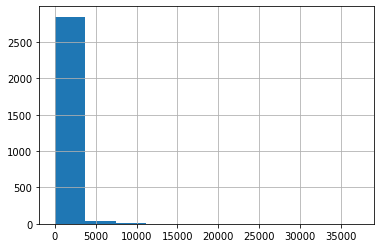

In [ ]:
X_intervals.intervals.hist()

In [ ]:
X_intervals[X_intervals.intervals > 1000]

,test_cas,species,conc1_mean,obs_duration_mean,score,prediction,intervals
4,583,395,910.0,96.0,0.001099,1978.023551,1068.023551
18,444,44,720.0,96.0,0.001389,1742.417771,1022.417771
27,464,316,855.0,96.0,0.001170,2001.831335,1146.831335
49,1371,316,14100.0,96.0,0.000071,22680.563909,8580.563909
59,921,316,801.0,96.0,0.001248,1855.770691,1054.770691
...,...,...,...,...,...,...,...
2787,2049,74,10000.0,96.0,0.000100,15661.490095,5661.490095
2830,418,7,8000.0,96.0,0.000125,14665.623628,6665.623628
2841,1494,220,9000.0,96.0,0.000111,15009.266397,6009.266397
2862,126,316,6410.0,96.0,0.000156,11494.356127,5084.356127


# FIRST BEST COMBINATION FOUND
scale = 5, best_params = [{'best_factor': 10,
  'best_lin_regulariz': 2.1544346900318868e-11,
  'best_regulariz': 0.0021544346900318778},
 {'best_factor': 10,
  'best_lin_regulariz': 1e-08,
  'best_regulariz': 0.0021544346900318778},
 {'best_factor': 10,
  'best_lin_regulariz': 0.0001,
  'best_regulariz': 2.1544346900318822e-07}]

In [ ]:
best_params

[{'best_factor': 10,
  'best_lin_regulariz': 2.1544346900318868e-11,
  'best_regulariz': 0.0021544346900318778},
 {'best_factor': 10,
  'best_lin_regulariz': 1e-08,
  'best_regulariz': 0.0021544346900318778},
 {'best_factor': 10,
  'best_lin_regulariz': 0.0001,
  'best_regulariz': 2.1544346900318822e-07}]

In [ ]:
X_test_sc = X_test_scored.copy()
X_train_sc = X_train_scored.copy()

minmax = MinMaxScaler((1, 5))
minmax.fit(X_train_sc[["score"]])
X_train_sc[["score"]] = minmax.transform(X_train_sc[["score"]])

minmax = MinMaxScaler((1, 5))
minmax.fit(X_test_sc[["score"]])
X_test_sc[["score"]] = minmax.transform(X_test_sc[["score"]])

model_test = tc.recommender.factorization_recommender.create(tc.SFrame(X_train_sc), 'test_cas', 'species', target='score', max_iterations=1000, \
                                                                       num_factors = 10, regularization=0.0021544346900318778, linear_regularization=2.1544346900318868e-11, solver="sgd", verbose=True)

Preparing data set.

Data has 5896 observations with 2108 users and 359 items.

Data prepared in: 0.011115s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 10       |

| regularization                 | L2 Regularization on Factors                     |          |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 2.15e-11 |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 5896 / 5896 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 5.76453           | Not Viable                               |

| 1       | 1.44113           | Not Viable                               |

| 2       | 0.360283          | Not Viable                               |

| 3       | 0.0900708         | 0.0709072                                |

| 4       | 0.0450354         | 0.0946184                                |

| 5       | 0.0225177         | 0.131762                                 |

| 6       | 0.0112588         | 0.17232                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0900708         | 0.0709072                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 73us         | 0.335026          | 0.578814              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 13.218ms     | 0.211822          | 0.460238              | 0.0900708   |

| 2       | 23.965ms     | 0.10946           | 0.330844              | 0.0420081   |

| 3       | 27.964ms     | 0.0899232         | 0.299868              | 0.0273917   |

| 4       | 35.492ms     | 0.0804164         | 0.283573              | 0.0203211   |

| 5       | 42.133ms     | 0.0748571         | 0.273595              | 0.0161518   |

| 10      | 68.734ms     | 0.0629312         | 0.250854              | 0.00797287  |

| 50      | 288.622ms    | 0.0487196         | 0.220718              | 0.00157846  |

| 100     | 571.412ms    | 0.0453467         | 0.212941              | 0.000788237 |

| 500     | 2.84s        | 0.0403949         | 0.200982              | 0.000157488 |

| 614     | 3.49s        | 0.0399523         | 0.199878              | 0.000128242 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.0399303

Final training RMSE: 0.199823

In [ ]:
model_test.evaluate_rmse(tc.SFrame(X_test_sc), 'score')['rmse_overall']

0.5610883041591249

In [ ]:
X_test_predict = model_test.predict(tc.SFrame(X_test_sc))
X_test_predict

dtype: float
Rows: 2904
[2.9195034845434287, 3.266156184956364, 2.3611241867758133, 1.6044036625689126, 2.275789453186795, 2.466074143073565, 2.4856443017586067, 2.111793257395368, 2.359067423628171, 2.1542916652169444, 2.5145106899974383, 2.533834329233964, 2.509174032495816, 2.5607520140572384, 3.1240857906019763, 3.3695670138193576, 2.4058036833827803, 2.381695335397637, 1.982446919393324, 2.8640639580363634, 2.4696540370448425, 2.6758172865965926, 3.768743933576838, 3.48426780894601, 2.415248392508824, 2.1045070308744362, 2.415248392508824, 2.415248392508824, 2.3616943446886567, 2.239184864856656, 2.586345306441618, 3.9560453261735287, 1.962683386529188, 3.2192800414159692, 2.2571492151423134, 3.1691503532236482, 2.663841177701599, 2.5363449918002012, 2.0459626949963243, 2.7536302540466124, 2.533834329233964, 3.5981925772436854, 2.509174032495816, 1.961907488490747, 2.415248392508824, 2.567272471397312, 2.0097729383946565, 2.3834558302303024, 1.9825248706776368, 2.415248392508824, 

In [ ]:
X_test_sc

,test_cas,species,score
0,70,294,3.290765
1,104,138,3.465897
2,1551,72,2.897733
3,810,319,1.918792
4,583,395,2.076326
...,...,...,...
2899,820,220,3.462946
2900,230,174,2.923584
2901,1713,220,4.363339
2902,1213,316,2.854852


In [ ]:
X_test_predict_conc = minmax.inverse_transform(X_test_predict.to_numpy().reshape(-1, 1))
X_test_predict_conc = np.exp(X_test_predict_conc)    
X_test_predict_conc = 1/X_test_predict_conc

In [ ]:
sqrt(mean_squared_error(X_test_original.conc1_mean.values, X_test_predict_conc))

10949.70164859497

In [ ]:
X_intervals = compute_absolute_intervals(X_test_original, X_test_predict_conc)
X_intervals.head()

,test_cas,species,conc1_mean,obs_duration_mean,score,prediction,intervals
0,70,294,0.80,96.0,1.250000,6.875650,6.075650
1,104,138,0.29,96.0,3.448276,0.922603,0.632603
2,1551,72,7.80,96.0,0.128205,174.739263,166.939263
3,810,319,2267.00,96.0,0.000441,14014.024103,11747.024103
4,583,395,910.00,96.0,0.001099,286.498536,623.501464
